<h1 style = "text-align:center"> Chatbot for Restaurant Receptionist </h1>
<p1> This is a chatbot that can greet customers, give recommendations, make reservations and more! </p1>


<h2>Libraries</h2>
The main libraries that are used are tensorflow2, keras , numpy and pandas

In [66]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from gtts import gTTS
import os

<h2> Importing the Data </h2>

The data is stored in a json file, which can be imported and used as a pandas dataframe.
This data was manually created. Hence, it's not that big.<br>

In [67]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [68]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [69]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [70]:
#printing the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,hi,greeting
4,hey there,greeting
...,...,...
104,for a table at 4pm,time
105,for a table at 1pm,time
106,looking at 1pm,time
107,looking at 2pm,time


In [71]:
data = data.sample(frac=1)

<h2> Pre-Processing </h2>

Important pre-processing such as removing the punctuations, converting to lowercase, encoding the textual data to numerical data are done

In [72]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
98,am,time
101,reserving a table at this time,time
55,what would you recommend,recommendations
38,5,guests
26,three,guests
...,...,...
18,table for,reservations
94,any spicy dishes to recommend me,spicy
73,i like savoury food,savoury
7,hi nice to meet you,greeting


In [73]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

Tensorflow's tokenizer assigns a unique token to each distinct word. and padding is done to get all the data to the same length as to send it to an RNN layer

In [74]:
input_shape = x_train.shape[1]
print(input_shape)

9


In [75]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  113
output length:  10


<h2>Neural Network</h2>

The Network consist of an embedding layer which is one of the most powerful things in the field of natural language processing. the outputs of the embedding layer is the input of the recurrent layer with lstm gate. then, the output is flattened and a regular dense layer is used with a softmax activation function.

The main part is the embedding layer which gives a corresponding vector for each word in the dataset

In [76]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [77]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [78]:
#training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
4/4 [==============================] - 3s 5ms/step - loss: 2.3013 - accuracy: 0.0642
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2978 - accuracy: 0.2110
Epoch 3/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2946 - accuracy: 0.1835
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2920 - accuracy: 0.1743
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2883 - accuracy: 0.1835
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2847 - accuracy: 0.1835
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2802 - accuracy: 0.1835
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2762 - accuracy: 0.1835
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2712 - accuracy: 0.1835
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 2.2666 - accuracy: 0.1835
Epoch 11/200
4/4 [===========

<h2> Model Analysis </h2>

The model got an accuracy of over 95% after 200 epoch.

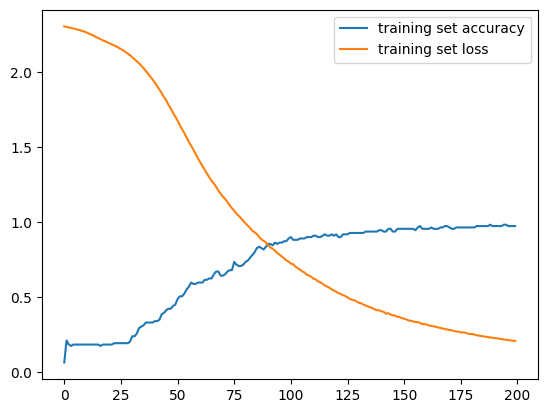

In [79]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

<h2> Testing </h2>



In [65]:
#chatting
import random

while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]

  #getting output text and output it as speech
  response = random.choice(responses[response_tag])
  print("Receptionist: ",response)
  speech = gTTS(text=response, lang='en', slow=False)
  speech.save("speech.mp3")
  os.system("speech.mp3")

  #end conversation if users says goodbye
  if response_tag == "goodbye":
    break

Receptionist:  We are located at 9 Engineering Drive 1, #07-26 EA, Singapore 117575
Receptionist:  We have reserved a slot for you
Receptionist:  We have reserved a slot for you
Receptionist:  We have reserved a slot for you
Receptionist:  You're welcome, we look forward to seeing you soon


<h2> Conclusion </h2>
So, This is the Chatbot that I have created with tensorflow2 utilizing the power of embedding matrix.<br>
This was created in memory og <b> Going Merry </b> , a ship from a manga called "One Piece" which revolves around the story of 5 pirates. 